Loaded 119 periods
Missing Periods:
  missing_start missing_end  gap_days
0    2021-09-04  2021-11-08      94.0
After imputation: 122 rows (3 imputed)


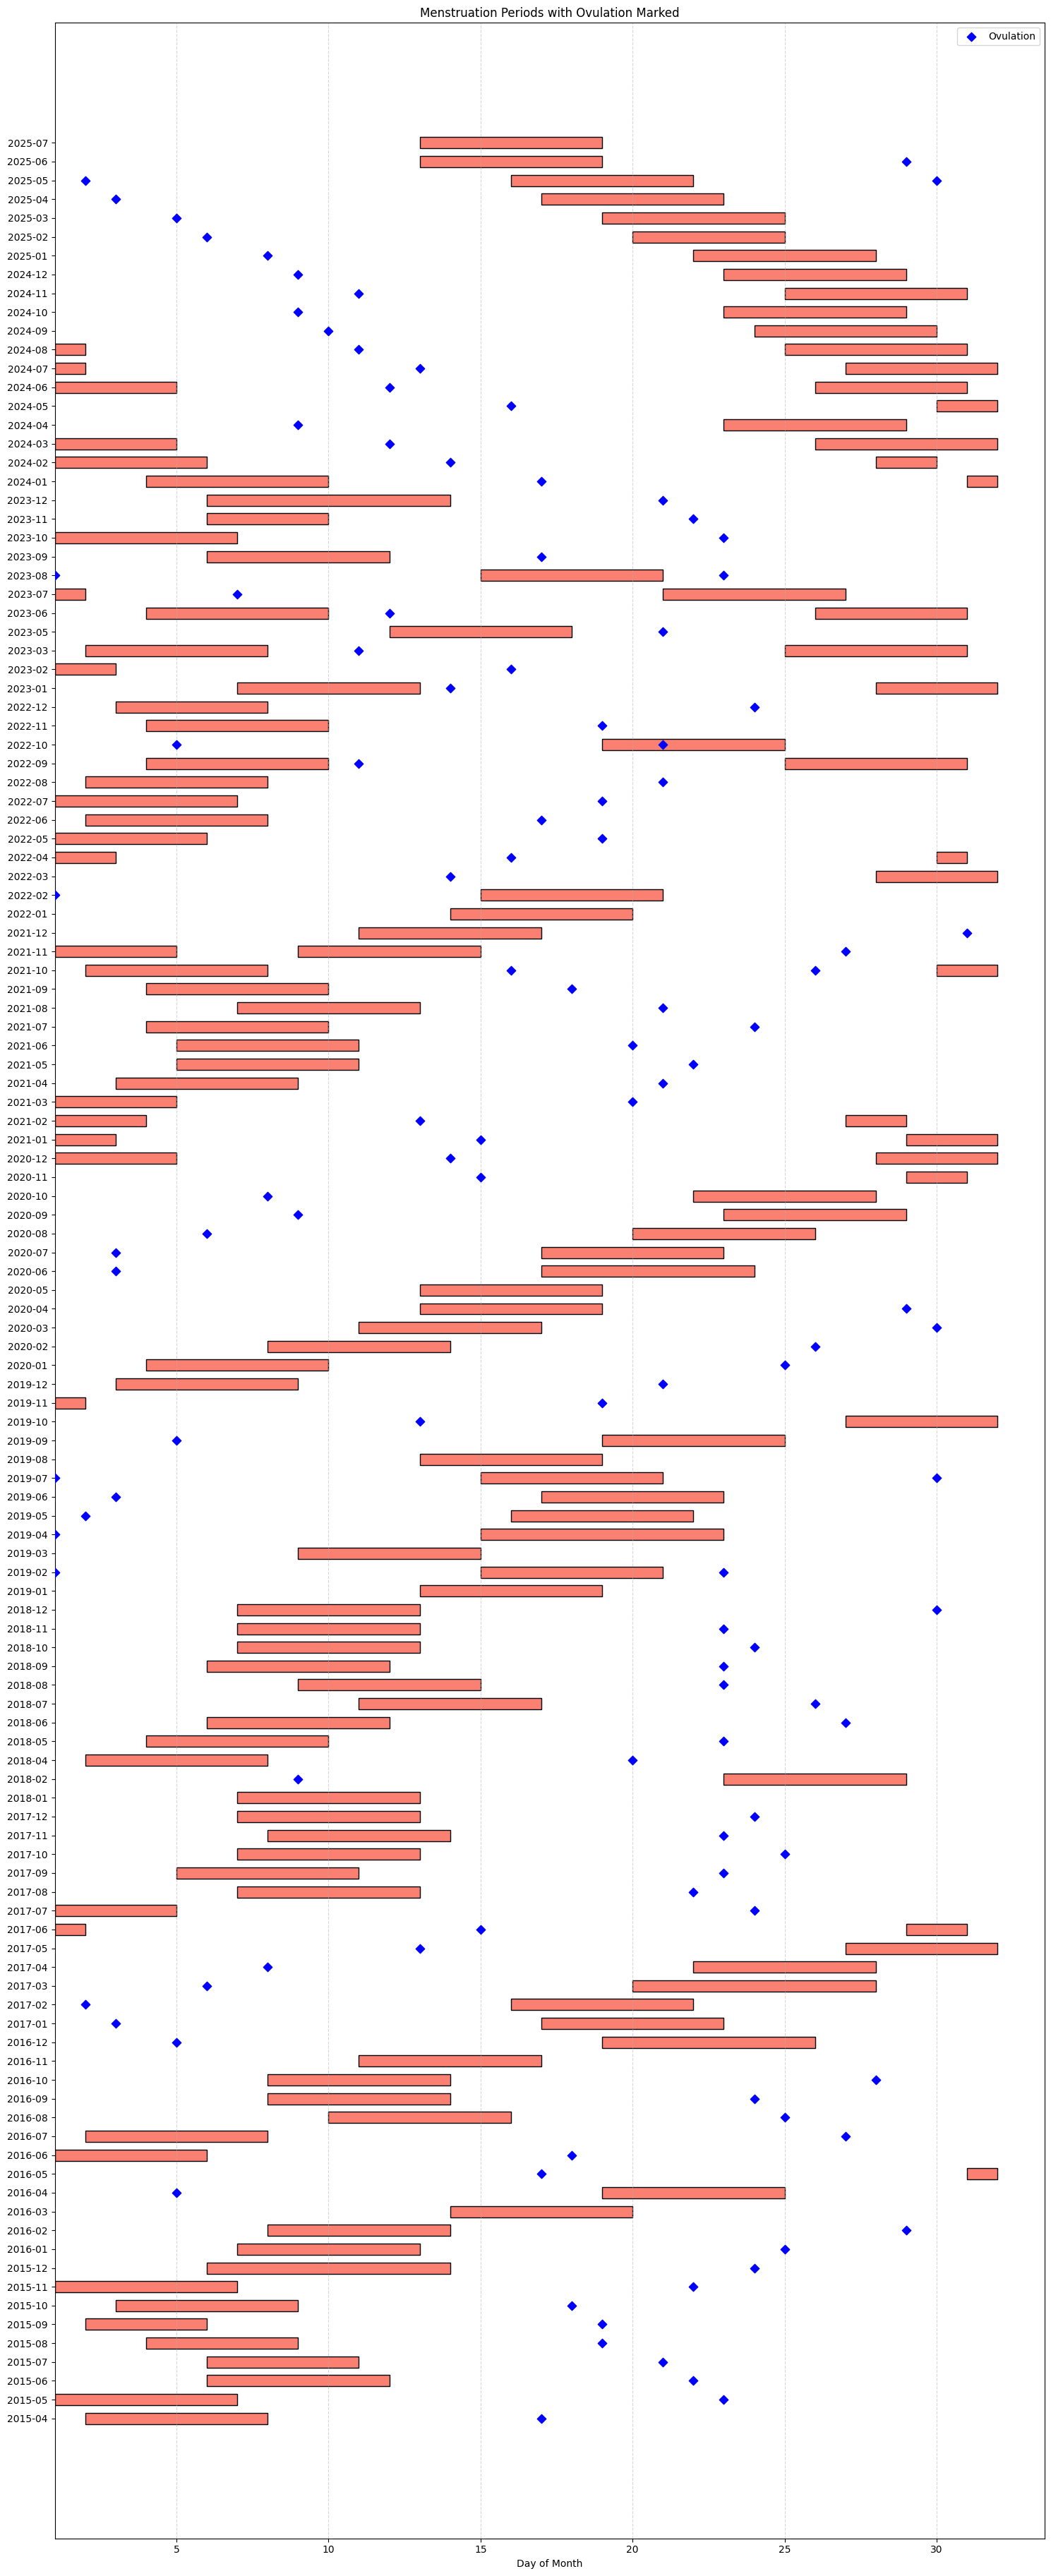

In [2]:
# ========================================
# 📅 01_period_analysis.ipynb — Menstrual Cycle Analysis
# ========================================

import pandas as pd
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
from pandas.tseries.offsets import MonthEnd
import math

# =====================
# Config
# =====================
PERIOD_FILE = "data/period.xml"  # menstrual cycle XML file
MISSING_THRESHOLD_DAYS = 48      # threshold for missing period detection
AVG_CYCLE_DAYS = 28              # default average cycle
DEFAULT_DURATION = 6              # default duration if missing


# =====================
# 1. Load Data
# =====================
def load_period_data(file_path):
    """Load menstrual period data from XML and return DataFrame."""
    try:
        tree = ET.parse(file_path)
        root = tree.getroot()
    except Exception as e:
        raise ValueError(f"Error parsing XML: {e}")

    data = []
    for menstruation in root.find("menstruation_list").findall("menstruation"):
        begin = menstruation.find("begin").text
        end = menstruation.find("end").text
        data.append({"begin": begin, "end": end})

    df = pd.DataFrame(data)
    df["begin"] = pd.to_datetime(df["begin"], errors="coerce")
    df["end"] = pd.to_datetime(df["end"], errors="coerce")
    df["duration_days"] = (df["end"] - df["begin"]).dt.days + 1

    return df.dropna(subset=["begin", "end"]).sort_values("begin").reset_index(drop=True)


# =====================
# 2. Detect Missing Periods
# =====================
def detect_missing_periods(df, threshold=MISSING_THRESHOLD_DAYS):
    """Return DataFrame of missing period intervals."""
    df = df.copy()
    df["next_begin"] = df["begin"].shift(-1)
    df["cycle_length"] = (df["next_begin"] - df["begin"]).dt.days

    missing = df[df["cycle_length"] > threshold]
    results = []
    for _, row in missing.iterrows():
        expected_start = row["begin"] + pd.Timedelta(days=AVG_CYCLE_DAYS)
        expected_end = row["next_begin"] - pd.Timedelta(days=1)
        results.append({
            "missing_start": expected_start,
            "missing_end": expected_end,
            "gap_days": row["cycle_length"]
        })
    return pd.DataFrame(results)


# =====================
# 3. Impute Missing Periods
# =====================
def fill_missing_periods(df, threshold=48, default_cycle=28, default_duration=6):
    df = df.sort_values('begin').reset_index(drop=True)
    new_rows = []

    for i in range(len(df) - 1):
        current = df.loc[i, 'begin']
        next_ = df.loc[i + 1, 'begin']
        diff = (next_ - current).days

        if diff > threshold:
            # Estimate missing count directly from default_cycle
            n_missing = max(0, math.ceil(diff / default_cycle) - 1)

            for j in range(n_missing):
                new_begin = current + pd.Timedelta(days=default_cycle * (j + 1))
                new_end = new_begin + pd.Timedelta(days=default_duration - 1)
                new_rows.append({
                    'begin': new_begin,
                    'end': new_end,
                    'duration_days': default_duration,
                    'imputed': True
                })

    df_new = pd.DataFrame(new_rows)
    df['imputed'] = False
    df_filled = pd.concat([df, df_new], ignore_index=True).sort_values('begin').reset_index(drop=True)
    return df_filled



# =====================
# 4. Derived Fields
# =====================
def calculate_derived_fields(df):
    """Add cycle length, year, season, ovulation date, etc."""
    df = df.copy()
    df["next_begin"] = df["begin"].shift(-1)
    df["cycle_length"] = (df["next_begin"] - df["begin"]).dt.days
    df["year"] = df["begin"].dt.year
    df["month"] = df["begin"].dt.month

    season_map = {12: "Winter", 1: "Winter", 2: "Winter",
                  3: "Spring", 4: "Spring", 5: "Spring",
                  6: "Summer", 7: "Summer", 8: "Summer",
                  9: "Fall", 10: "Fall", 11: "Fall"}
    df["season"] = df["month"].map(season_map)
    
    df["ovulation_date"] = np.where(
    df["cycle_length"].notna(),
    df["begin"] + pd.to_timedelta(df["cycle_length"] - 14, unit="D"),
    pd.NaT)

    df["ovulation_date"] = df["begin"] + pd.to_timedelta(df["cycle_length"] - 14, unit="D")
    return df


# =====================
# 5. Visualization
# =====================
def plot_split_month_bars_with_ovulation(df):
    """
    Plot period bars split across months and mark ovulation dates.
    Assumes 'ovulation_date' is already in df.
    """
    split_rows = []
    ovulation_marks = []

    for _, row in df.iterrows():
        start = row["begin"]
        end = row["end"]
        ovulation = row.get("ovulation_date", None)

        # Split period into month segments
        months = pd.period_range(start=start.to_period("M"), end=end.to_period("M"), freq="M")
        for month_period in months:
            year_month = str(month_period)
            month_start = month_period.to_timestamp()
            month_end = month_start + MonthEnd(0)

            seg_start = max(start, month_start)
            seg_end = min(end, month_end)

            split_rows.append({
                "year_month": year_month,
                "start_day": seg_start.day,
                "end_day": seg_end.day
            })

        # If ovulation falls in this month range, store it
        if pd.notnull(ovulation):
            year_month_ov = ovulation.to_period("M").strftime("%Y-%m")
            ovulation_marks.append({
                "year_month": year_month_ov,
                "ov_day": ovulation.day
            })

    df_split = pd.DataFrame(split_rows)
    df_ov = pd.DataFrame(ovulation_marks)

    # Y-axis mapping
    labels = sorted(df_split["year_month"].unique())
    label_to_y = {label: i for i, label in enumerate(labels)}

    plt.figure(figsize=(15, len(labels) * 0.3))

    # Draw period bars
    for _, row in df_split.iterrows():
        y = label_to_y[row["year_month"]]
        width = row["end_day"] - row["start_day"] + 1
        plt.barh(y=y, width=width, left=row["start_day"], height=0.6,
                 color="salmon", edgecolor="black")

    # Draw ovulation markers
    for _, row in df_ov.iterrows():
        if row["year_month"] in label_to_y:
            y = label_to_y[row["year_month"]]
            plt.scatter(row["ov_day"], y, color="blue", s=40, zorder=5, label="Ovulation", marker = 'D')

    # Handle legend to avoid duplicates
    handles, labels_unique = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels_unique, handles))
    plt.legend(by_label.values(), by_label.keys(), loc="upper right")

    plt.yticks(range(len(label_to_y)), label_to_y.keys())
    plt.xlabel("Day of Month")
    plt.title("Menstruation Periods with Ovulation Marked")
    plt.grid(axis="x", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


# =====================
# Main Execution
# =====================
if __name__ == "__main__":
    # Load
    df_periods = load_period_data(PERIOD_FILE)
    print(f"Loaded {len(df_periods)} periods")

    # Detect Missing
    missing_df = detect_missing_periods(df_periods)
    print("Missing Periods:")
    print(missing_df)

    # Impute Missing
    df_filled = fill_missing_periods(df_periods)
    print(f"After imputation: {len(df_filled)} rows ({df_filled['imputed'].sum()} imputed)")

    # Add derived fields
    df_final = calculate_derived_fields(df_filled)

    # Save
    df_final.to_csv("data/period_clean.csv", index=False)

    # Plots
    plot_split_month_bars_with_ovulation(df_final)
